In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
import requests
from sklearn.preprocessing import MinMaxScaler
from requests_html import HTMLSession
from sklearn.model_selection import train_test_split
from finta import TA
import json
import torch as th

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2
    TAKE = 3

In [4]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers=ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [5]:
def calculate_percentage_increase(final_value, starting_value):
    try:
        return 100 * ((final_value - starting_value) / starting_value)
    except:
        print(final_value, starting_value)

In [6]:
def supertrend_indicator(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]

            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return final_lowerband, final_upperband

In [7]:
def rsi_indicator(df):
    rsi = TA.RSI(df[['open', 'high', 'low', 'close']], 14)

    signals = []
    for i in range(0, len(rsi)):
        if rsi[i] > 60: # Default value: 70
            signals.append(Positions.SHORT)
        elif rsi[i] < 40: # Default value: 30
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [8]:
def swing_detection(index, df):
    sh = []
    sl = []
    start = (index*2) - 1
    for i in range(index-1):
        sh.append(False)
        sl.append(False)
    for ci, row in df.iterrows():
        
        swing_high = False
        swing_low = False
        
        if ci < start:
            continue
        
        swing_point_high = df['high'][ci - index]
        swing_point_low = df['low'][ci - index]
        
        for i in range(0, start):
            swing_high = True
            if i < index:
                if df['high'][ci - i] > swing_point_high:
                    swing_high = False
                    break
            if i > index:
                if df['high'][ci - i] >= swing_point_high:
                    swing_high = False
                    break
            
        for i in range(0, start):
            swing_low = True
            if i < index:
                if df.low[ci - i] < swing_point_low: 
                    swing_low = False
                    break  
            if i > index:
                if df.low[ci - i] <= swing_point_low: 
                    swing_low = False
                    break 
            
        sh.append(swing_high)
        sl.append(swing_low)
        
    for i in range(index):
        sh.append(False)
        sl.append(False)
        
    current_sh = 0
    current_sl = 0
    sh_nums = []
    sl_nums = []
    for i, row in df.iterrows():
        if sh[i] == True:
            current_sh = df.high[i]
        if sl[i] == True:
            current_sl = df.low[i]
        sh_nums.append(current_sh)
        sl_nums.append(current_sl)
    return sh, sl, sh_nums, sl_nums

In [9]:
def money_flow_index_indicator(df, period=14):
    # Calculate typical price (TP) for each period
    df['TP'] = (df['high'] + df['low'] + df['close']) / 3

    # Calculate raw money flow (RMF) for each period
    df['RMF'] = df['TP'] * df['volume']

    # Calculate positive and negative money flow
    df['PMF'] = 0.0
    df['NMF'] = 0.0

    for i in range(1, len(df)):
        if df.at[i, 'TP'] > df.at[i - 1, 'TP']:
            df.at[i, 'PMF'] = df.at[i, 'TP'] * df.at[i, 'volume']
        elif df.at[i, 'TP'] < df.at[i - 1, 'TP']:
            df.at[i, 'NMF'] = df.at[i, 'TP'] * df.at[i, 'volume']

    # Calculate money flow ratio (MFR)
    df['MFR'] = df['PMF'].rolling(window=period).sum() / df['NMF'].rolling(window=period).sum()

    # Calculate Money Flow Index (MFI)
    df['MFI'] = 100 - (100 / (1 + df['MFR']))

    # Remove temporary columns
    df.drop(['TP', 'RMF', 'PMF', 'NMF', 'MFR'], axis=1, inplace=True)

    return df['MFI'].values

In [10]:
def produce_prediction(df, window):  
    prediction = (df.shift(window)['close'] <= df['close'])
    
    return prediction.astype(int)

In [11]:
def preprocess_data(df, remove_date = False):
    scaler = MinMaxScaler()
    
    mfi_indicator = money_flow_index_indicator(df)
    close_b = produce_prediction(df, 1)
    rsi_signals, _, _ = rsi_indicator(df)
    sh, sl, sh_nums, sl_nums = swing_detection(5, df)    
    final_lowerband, final_upperband = supertrend_indicator(df, 10, 3)
    fu_modified = [Positions.LONG if not np.isnan(lowerband) else Positions.SHORT for lowerband in final_lowerband]

    df['close_binary'] = close_b
    df['mfi'] = mfi_indicator
    df['sh_nums'] = sh_nums
    df['sl_nums'] = sl_nums
    df['supertrend'] = fu_modified
    df['rsi_signals'] = rsi_signals
    
    df = df.drop(columns={"volume", "open", "high", "low", "MFI"})
    df = df.dropna()
    if remove_date:
        df = df.drop(columns={'date'})
        
    if "Adj Close" in df.columns:
        df = df.drop(columns={'Adj Close'})
    
    df[['mfi', 'rsi_signals']] = scaler.fit_transform(df[['mfi', 'rsi_signals']])
    
    return df

In [111]:
#df = getTickerData('btc-usd', '220d', '1d')
#df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
data_query = 'symbol=BTCUSDT&interval=1d&limit=1500'
HOST_URL = 'https://testnet.binancefuture.com'
END_POINT = '/fapi/v1/markPriceKlines'
SECOND_END_POINT = '/fapi/v1/klines'
url = HOST_URL + END_POINT + "?" + data_query
data = requests.get(url=url).text
data = json.loads(data)
df_data = {'open': [], 'high': [], 'low': [], 'close': [], 'volume': []}
for i in range(0, len(data)):
    open = data[i][1]
    high = data[i][2]
    low = data[i][3]
    close = data[i][4]
    df_data['open'].append(open)
    df_data['high'].append(high)
    df_data['low'].append(low)
    df_data['close'].append(close)
    
df_data['volume'] = df_data['close']
    
df = pd.DataFrame(df_data)
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric)
df

,open,high,low,close,volume
0,7498.715749,7688.921237,7269.063078,7318.308710,7318.308710
1,7318.256867,7432.283941,7164.366831,7257.500019,7257.500019
2,7257.499994,7268.977941,7131.309606,7203.166389,7203.166389
3,7203.593636,7430.745541,7159.195679,7202.130934,7202.130934
4,7202.130909,7269.529990,7093.538626,7253.475820,7253.475820
...,...,...,...,...,...
1495,39960.588351,42296.546526,39909.006643,41819.426554,41819.426554
1496,41819.422198,42182.000000,41510.983331,42102.200000,42102.200000
1497,42102.200000,42788.698592,41636.793539,42032.356332,42032.356332
1498,42032.352680,43297.600000,41818.165138,43287.600000,43287.600000


In [12]:
session = HTMLSession()
num_currencies=1
symbols_to_remove = ['USDT-USD', 'USDC-USD', 'BNB-USD', 'XRP-USD', 'DOGE-USD', 'SOL-USD', 'WTRX-USD', 'TRX-USD']
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
symbols_yf = df.Symbol.tolist()
# for symbol in symbols_to_remove:
#     print(symbol)
#     symbols_yf.remove(symbol)
print(symbols_yf)

['BTC-USD']


In [13]:
# only for binance api

dataframes = []
dataframes.append(df)

In [14]:
dataframes = []
for symbol in symbols_yf:
    print(symbol)
    # max 1d
    df = getTickerData(symbol, '730d', '1h')
    df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
    dataframes.append(df)

BTC-USD
[*********************100%***********************]  1 of 1 completed


In [15]:
preprocessed_dataframes = []
data = []
for df in dataframes:
    p_df = preprocess_data(df, remove_date=True) # False for binance api; True for yfinance
    if p_df.shape[1] == 7:
        preprocessed_dataframes.append(p_df)

In [16]:
preprocessed_dataframes[0]

,close,close_binary,mfi,sh_nums,sl_nums,supertrend,rsi_signals
13,30003.855469,0,0.734153,30230.126953,29275.183594,1,0.0
14,29946.494141,0,0.708914,30230.126953,29275.183594,1,0.0
15,29815.261719,0,0.700637,30230.126953,29710.179688,1,1.0
16,29906.453125,1,0.700637,30230.126953,29710.179688,1,1.0
17,29934.820312,1,0.727828,30230.126953,29710.179688,1,1.0
...,...,...,...,...,...,...,...
17424,66926.507812,0,0.868160,67668.765625,66374.000000,1,1.0
17425,67058.554688,1,0.902420,67668.765625,66374.000000,1,1.0
17426,66960.968750,0,0.784979,67668.765625,66374.000000,1,1.0
17427,67405.492188,1,0.805485,67668.765625,66374.000000,1,0.0


In [17]:
training_data = []
testing_data = []
for df in preprocessed_dataframes:
    train, test = train_test_split(df, train_size=1, shuffle=False)
    training_data.append(train.dropna())
    testing_data.append(test.dropna())

In [18]:
amount_of_training_rows = 0
amount_of_testing_rows = 0
for df in training_data:
    print(df.shape)
    amount_of_training_rows += df.shape[0]
print(f'total rows of training data - {amount_of_training_rows}')
for df in testing_data:
    print(df.shape)
    amount_of_testing_rows += df.shape[0]
print(f'total rows of testing data - {amount_of_testing_rows}')

(1, 7)
total rows of training data - 1
(16542, 7)
total rows of testing data - 16542


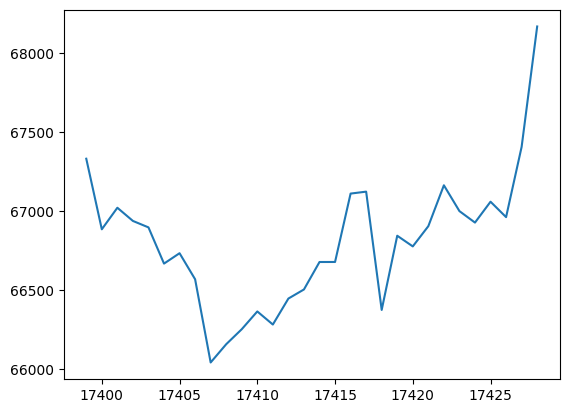

In [19]:
plt.plot(testing_data[0]['close'].tail(30))

In [20]:
training_data[0].head()

,close,close_binary,mfi,sh_nums,sl_nums,supertrend,rsi_signals
13,30003.855469,0,0.734153,30230.126953,29275.183594,1,0.0


In [21]:
#for i in range(0, len(preprocessed_dataframes)):
#    if 0 in preprocessed_dataframes[i]['close']:
#        print(True)
#        print(i)

In [22]:
class TradingEnv(Env):
    def __init__(self, df, max_n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df[0].shape[1]-3), dtype=np.float64)
        self.action_space = Discrete(len(Positions)-1)
        self.done = None
        
        self.current_step = 0
        self.max_n_steps = max_n_steps
        self.needed_space = self.window_size + self.max_n_steps
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        #self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
        self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
        self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
        self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']
        
        self.positions = []
        self.current_pos = None
        self.amount_of_positions_taken = 0
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0   
        self.portfolio = 1   
        self.stop_loss_value = 0
        self.take_profit_value = 0
        self.position_swing_low = 0
        self.position_swing_high = 0
        
        self.done_searching_swing_low = False
        self.done_searching_swing_high = False
        self.done_assigning_stop_loss_and_take_profit = False
        self.done_with_position = False
        
    def step(self, action):
        reward = 0
        done = False
        info = {'t': 0, 'p': 0}
        
        while not self.done_with_position:
            self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
            self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
            #self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
            self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
            self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']

            if self.in_a_pos:
                action = Positions.HOLD
                
            #if action != self.current_supertrend and not self.in_a_pos:
                #action = Positions.HOLD
                    
            if action != Positions.HOLD:
                self.current_pos = action
                self.amount_of_positions_taken+=1
                self.held_price = self.final_value
                self.in_a_pos = True
                self.done_searching_swing_low = False
                self.done_searching_swing_high = False
                self.done_assigning_stop_loss_and_take_profit = False
                
            if self.held_price == 0:
                #print("Invalid trade")
                self.current_step += 1
                if self.current_step >= self.max_n_steps:
                    done = True
                else:
                    done = False
                reward = 0
                info = {'t': 0, 'p': 0}
                self.positions.append(action)
                self.done_with_position = True
                break
            
            if action == Positions.HOLD and not self.in_a_pos:
                #print("Hold position skip")
                self.current_step += 1
                if self.current_step >= self.max_n_steps:
                    done = True
                else:
                    done = False
                reward = 0
                info = {'t': 0, 'p': 0}
                self.positions.append(action)
                self.done_with_position = True
                break 
            
            reward, p, t, take_profit = self.calculate_reward(action)
            
            if take_profit:
                self.positions.append(Positions.TAKE)
                self.done_with_position = True
            else:
                self.positions.append(action)  
            
            self.current_step += 1
            if self.current_step >= self.max_n_steps:
                done = True
                self.done_with_position = True
            else:
                done = False
            
            if not self.done_with_position:    
                observation = self.get_observation()
                
            info = {'p': p, 't': t}
           
        self.done_with_position = False
        observation = self.get_observation()
        return observation, reward, done, info
        
    def reset(self):
        self.done_with_position = False
        self.current_step = 0
        next_observation = self.get_observation(is_random=True)
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        self.done = False
        self.positions.clear()
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
        #self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
        self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
        self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.portfolio = 1
        self.amount_of_positions_taken = 0
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_df = random.randint(0, len(self.df) - 1)
            self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        observationn = np.float64(self.df[self.random_df].iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].drop(columns={'close', 'sl_nums', 'sh_nums'}, axis=1).values)
        return observationn
    
    def final_render(self):
        final_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        sh_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['sh_nums']
        sl_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['sl_nums']
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        take_signal = [True if self.positions[n]==Positions.TAKE else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        take_signal.append(False)
        
        plt.figure(figsize=(24, 8))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=3, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.plot(final_observation, 'x', markersize=15, color='m', label = 'Take signal', markevery = take_signal)
        plt.plot(sh_observation, color='r', lw=2.)
        plt.plot(sl_observation, color='g', lw=2.)
        plt.plot()
        plt.xticks([])
        plt.title("Final result of the last trading session", fontsize=20)
        plt.ylabel('Close price', fontsize=15)
        plt.legend()
        plt.show()
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [23]:
class Trading(TradingEnv):
    def __init__(self, df, max_n_steps, window_size) -> None:
        super().__init__(df, max_n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05
        trade_done = False
        take_profit = False
        
        if self.current_pos == Positions.LONG:
            while not self.done_searching_swing_low:
                self.position_swing_low = self.swing_low
                self.done_searching_swing_low = True
                    
            if self.done_assigning_stop_loss_and_take_profit == False:
                self.stop_loss_value = self.position_swing_low
                self.take_profit_value = self.held_price + (self.held_price - self.position_swing_low) * 0.3
                self.done_assigning_stop_loss_and_take_profit = True

            if self.swing_low > self.position_swing_low:
                self.stop_loss_value = self.swing_low
            
            if self.final_value > self.take_profit_value:
                trade_done = True # take
            if self.final_value < self.stop_loss_value:
                trade_done = True # stop sell
                
        if self.current_pos == Positions.SHORT:
            while not self.done_searching_swing_high:
                self.position_swing_high = self.swing_high
                self.done_searching_swing_high = True
                    
            if not self.done_assigning_stop_loss_and_take_profit:
                self.stop_loss_value = self.position_swing_high
                self.take_profit_value = self.held_price - (self.position_swing_high - self.held_price) * 0.3
                self.done_assigning_stop_loss_and_take_profit = True
            
            if self.swing_high < self.position_swing_high:
                self.stop_loss_value = self.swing_high
            
            if self.final_value < self.take_profit_value:
                trade_done = True # take
            if self.final_value > self.stop_loss_value:
                trade_done = True # stop sell
        
        if self.in_a_pos and trade_done:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change 
            self.trading_positions+=1
            reward = total_profit
            
            #Reseting variables
            self.in_a_pos = False
            self.done_searching_swing_low = False
            self.done_searching_swing_high = False
            self.done_assigning_stop_loss_and_take_profit = False
            take_profit = True
            self.position_swing_low = 0
            self.position_swing_high = 0
            self.current_pos = None
            #print("Current step:", self.current_step)
            
        return reward, percentage, total_profit, take_profit

In [24]:
env = Trading(testing_data, window_size=89, max_n_steps=365)
env = Monitor(env)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


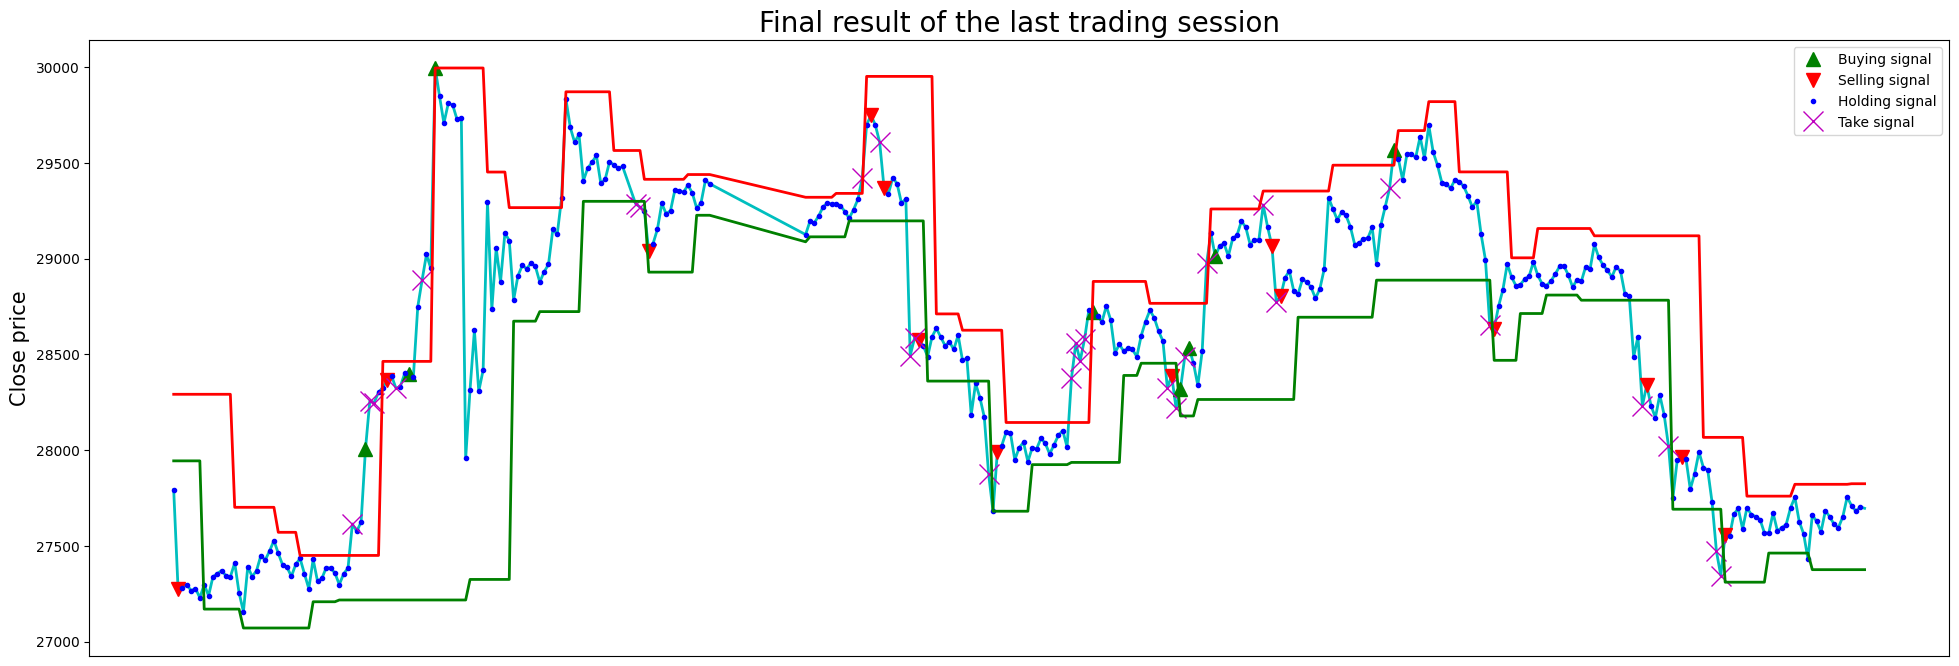

29
episode - 1 || score - 0.19097535803988835
0.19097535803988835


In [25]:
episodes = 1
for n in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        #print("Action", action)
        obs, reward, done, info = env.step(action)
        score += reward
        #print("REWARD", reward)
        #print('TOTAL_PROFIT', info['t'])
        #print('PERCENTAGE', info['p'])
        #print('INDICATOR_REWARD', info['i'])
        #print("Accumulated inc:", env.accumulated_percentage_increase)
        total_profit_ += info["t"]
    env.final_render()
    print(env.amount_of_positions_taken)
    print(f"episode - {n} || score - {score}")
    print(total_profit_)
    print('=' * 40)

In [27]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"
OPT_DIR = "./opt/"

In [28]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [25]:
policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch = [256, 128, 128, 192, 64, 16])

model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=8192,
    gamma=0.8148319613766952,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
    learning_rate=0.000011,
    policy_kwargs=policy_kwargs
)
print(model.policy)

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=192, bias=True)
      (7): ReLU()
      (8): Linear(in_features=192, out_features=64, bias=True)
      (9): ReLU()
      (10): Linear(in_features=64, out_features=16, bias=True)
      (11): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Li

In [72]:
# net_arch = dict(pi=[128,128,128,128], vf=[128,128,128,128])
policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[256, 256, 256, 256, 192, 192, 192, 128, 128, 128, 128, 128,  128, 64])

model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=8192,
    gamma=1.1,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
    learning_rate=0.0000011,
    policy_kwargs=policy_kwargs,
)

In [37]:
model = DQN(
    "MlpPolicy",
    env=env, verbose=0, 
    tensorboard_log=LOG_DIR,
    batch_size=8192, 
    learning_rate=0.004, 
    learning_starts=300000,
    gamma=0.9, 
    exploration_fraction=0.5)

In [26]:
loaded_model = RecurrentPPO.load("./saved_models/best_model_800000_LSTM4_original", env=env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
Exception: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
  warnings.warn(


In [ ]:
loaded_model = DQN.load("./saved_models/best_model_1000000", env=env)

In [23]:
loaded_model = PPO.load("./saved_models/best_model_800000_LSTM4_original", env=env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
Exception: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
  warnings.warn(


In [73]:
model.learn(total_timesteps=800000, callback=callback)

KeyboardInterrupt: 

In [37]:
def test_portfolio(model, starting_money, amount_to_use, total_episodes_to_run = 1):
    all_portfolio_accumulation_results = []
    all_final_portfolio_value = []
    all_score = []
    win = 0
    long = 0
    short = 0
    hold = 0
    trades = 0
    profitable_trades = 0
    
    for episode in range(1, total_episodes_to_run+1):
        obs = env.reset()
        done = False
        score = 0
        portfolio = starting_money
        portfolio_accumulation_results = []
        percentage_increase = 0
        total_profit = 0
    
        while not done:
            action, lstm_cells = model.predict(obs)
            if action == Positions.LONG:
                long+=1
                trades+=1
            elif action == Positions.SHORT:
                short+=1
                trades+=1
            else:
                hold+=1
                
            obs, reward, done, info = env.step(action)
            score += reward
            percentage_increase = info['p']

            if percentage_increase > 0 and action != Positions.HOLD:
                profitable_trades+=1
                
            total_profit += ((starting_money * amount_to_use) * percentage_increase * 0.01)
            portfolio_change = portfolio + ((starting_money * amount_to_use) * percentage_increase * 0.01)
            portfolio = portfolio_change
            portfolio_accumulation_results.append(portfolio_change)
        
        all_portfolio_accumulation_results.append(portfolio_accumulation_results)
        all_final_portfolio_value.append(portfolio)
        all_score.append(score)
        if total_profit > 0:
            win += 1
    
    if total_episodes_to_run <= 100:        
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 4.8)
        ax.axhline(y = starting_money, color = 'r', linestyle = '-', label = 'Starting money')
        for i in range(0, len(all_portfolio_accumulation_results)):
            ax.plot(all_portfolio_accumulation_results[i], label = 'Portfolio accumulation results' if total_episodes_to_run <= 3 else None)
            ax.legend(fontsize = 'large')
            plt.title('Portfolio accumulation results')
            plt.xlabel('Amount of trades done')
            plt.ylabel('Portfolio value')
            
    env.final_render()
    
    plt.title('Position distribution')
    plt.pie([long, short, hold], labels=['LONG', 'SHORT', 'HOLD'], autopct='%.2f')
    print(f'avg score - {np.average(all_score)}')
    print(f'avg final portfolio value - {np.average(all_final_portfolio_value)}')
    print(f'winrate - {win / total_episodes_to_run}')
    print(f'trade winrate - {profitable_trades / trades}')

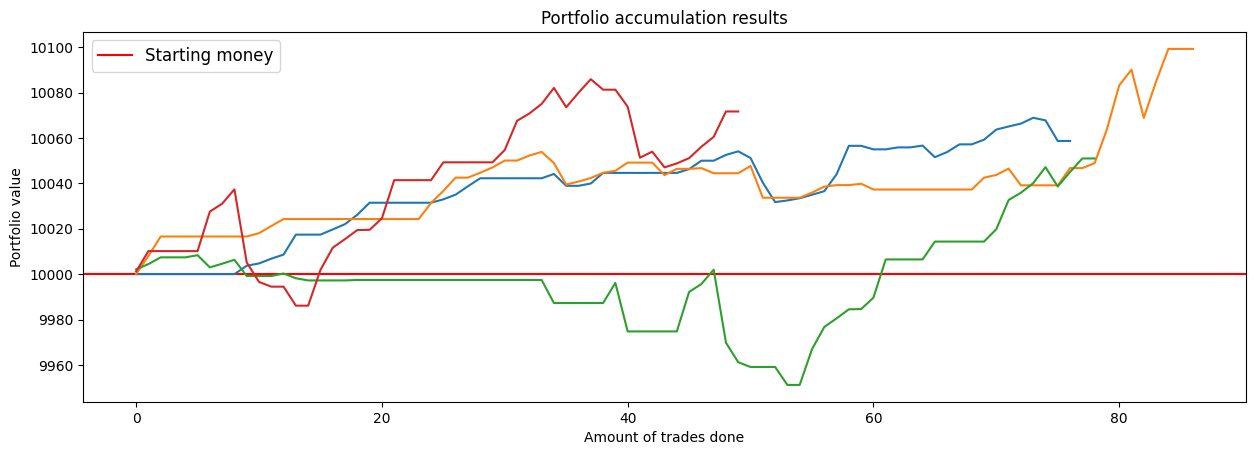

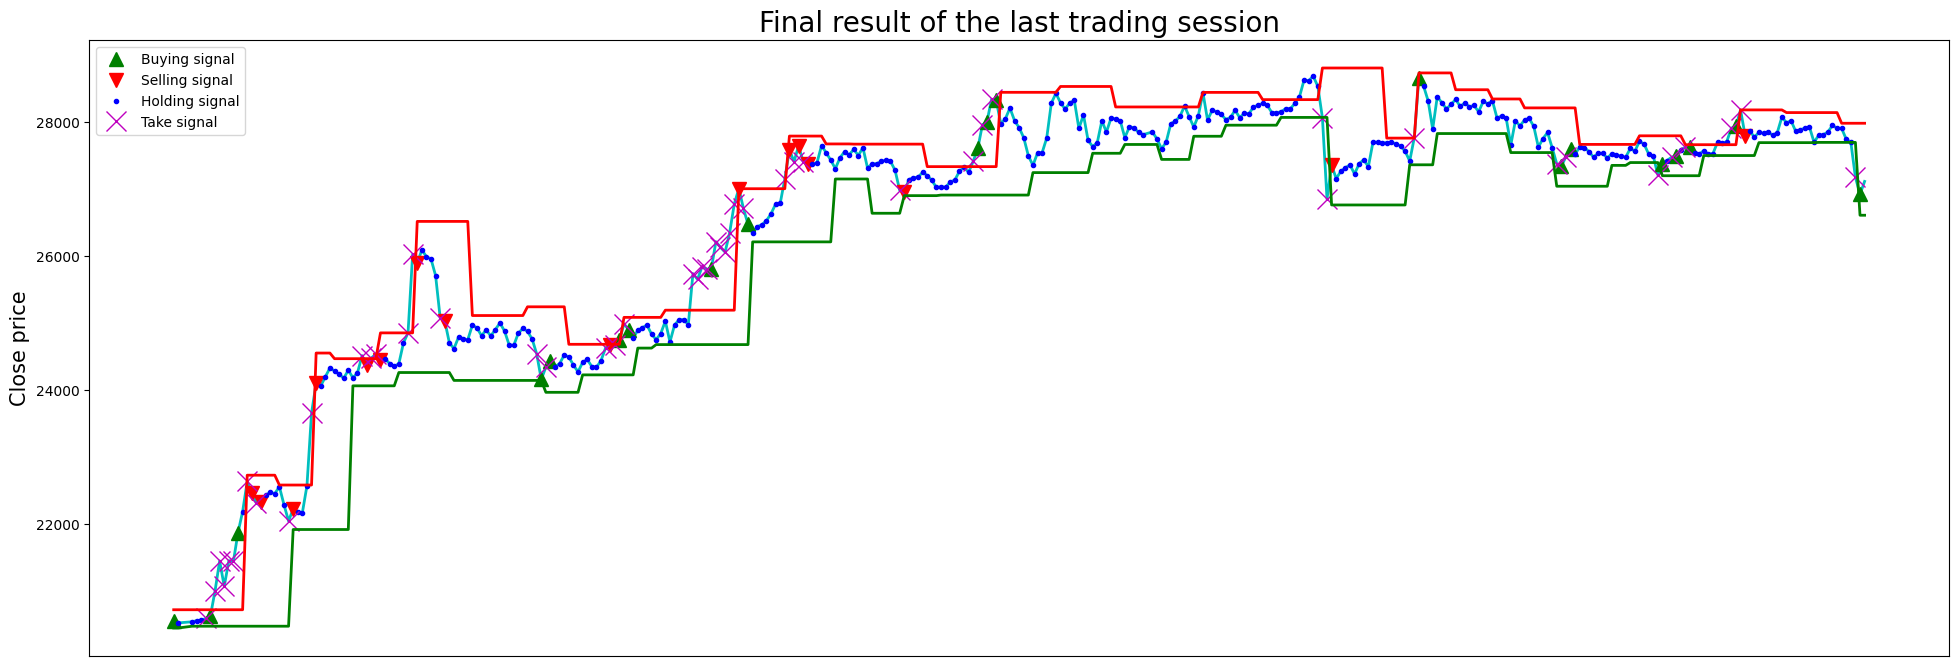

avg score - 0.7961367217828266
avg final portfolio value - 10070.141454218476
winrate - 1.0
trade winrate - 0.44086021505376344


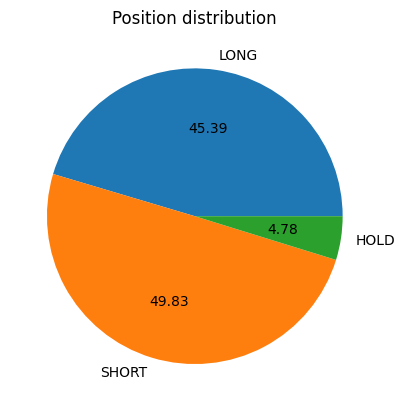

In [38]:
test_portfolio(loaded_model, starting_money=10000, amount_to_use=0.05, total_episodes_to_run=4)

In [66]:
loaded_model.predict(testing_data[0][['mfi', 'close_binary', 'supertrend', 'rsi_signals']].tail(89))[0]

array(1, dtype=int64)